# PJM Hourly Energy Consumption Forecasting Project

## DS675-854 Machine Learning Final Project

## Team Members
* John Vitz - EDA and XGBoost, Result Analysis <br>
* Matthew Pennington - Prophet and Neural Network Models <br>
* Cheuk Kay Mary Ng - EDA and Result Analysis, Report Compilation <br>

### Project References and Resources

- PJM Hourly Energy Consumption Data: [Kaggle Dataset](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption/data)
- Meteostat Weather Data: [Meteostat](https://meteostat.net/en/)
- Facebook's Prophet Model: [Prophet](https://facebook.github.io/prophet/)
- XGBoost Model: [XGBoost](https://xgboost.readthedocs.io/en/stable/)
- Tensorflow LSTM Model: [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)

In preparation for this project, a review of other public submissions and literature on Kaggle and academic journals was undertaken to ensure the adoption of best practices and to explore innovative modeling techniques.

---

## Background

The PJM Interconnection operates a competitive wholesale electricity market that helps to ensure the reliability of the largest electric grid in North America, serving parts of the Eastern and Midwestern United States. This project leverages the PJM hourly energy consumption data available on Kaggle, which provides insights into the patterns of electricity usage and pricing across different regions from around 2002 to 2018.

Electricity generation and consumption are fundamentally influenced by a complex network of power plants, which respond dynamically to the demands of the energy market managed by PJM. The cost of electricity fluctuates to encourage the cycling on and off of generation based on demand, which itself is influenced by daily and seasonal patterns, and can be disrupted by abnormal conditions such as extreme weather events.

### Objectives

The primary goal of this project is to develop models capable of forecasting future electricity consumption based on historical data. Accurate forecasts are crucial for:

- Informing trading decisions in the energy market.
- Scheduling of power plant maintenance during periods of low demand
- Enhancing the grid's reliability by anticipating changes in demand.

We focus on training several models that can perform realtime forecasting of data, forecasting MW demand up to 7 days into the future. This reflects the need for utilities to plan ahead for when they intend to bid into the energy market. Given accurate forecast data, a utility can maximize it's expected return on investment by selling power a points of highest expected demand.

### Data Overview

The dataset from Kaggle includes hourly measurements of electricity consumption (in megawatts, MW) and pricing across various PJM regions. This data exhibits cyclical behavior, influenced heavily by temperature variations and seasonal trends, such as increased air conditioning use during hot weather.

In our analysis, we are focused on the aggregate PJM Eastern region, labeled [PJME_hourly.csv](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption/data) in the Kaggle data source. This data only contains two columns, Datetime and PJME_MW, which is a measure of the combined MW consumption by hour for the entire PJM Eastern region.


| Datetime             | PJME_MW |
|----------------------|---------|
| 2002-12-31 01:00:00  | 26498.0 |
| 2002-12-31 02:00:00  | 25147.0 |
| 2002-12-31 03:00:00  | 24574.0 |
| 2002-12-31 04:00:00  | 24393.0 |
| 2002-12-31 05:00:00  | 24860.0 |
| 2002-12-31 06:00:00  | 26222.0 |
| 2002-12-31 07:00:00  | 28702.0 |
| 2002-12-31 08:00:00  | 30698.0 |
| 2002-12-31 09:00:00  | 31800.0 |
| 2002-12-31 10:00:00  | 32359.0 |
| 2002-12-31 11:00:00  | 32371.0 |
_Sample of PJME_MW data_

This subset of the data was selected since it is the largest sample to pull from.

# PJM Territory Map
## PJM East is composed of several territories, including NJ, Delaware, Maryland, DC, Virginia and Pennsylvania
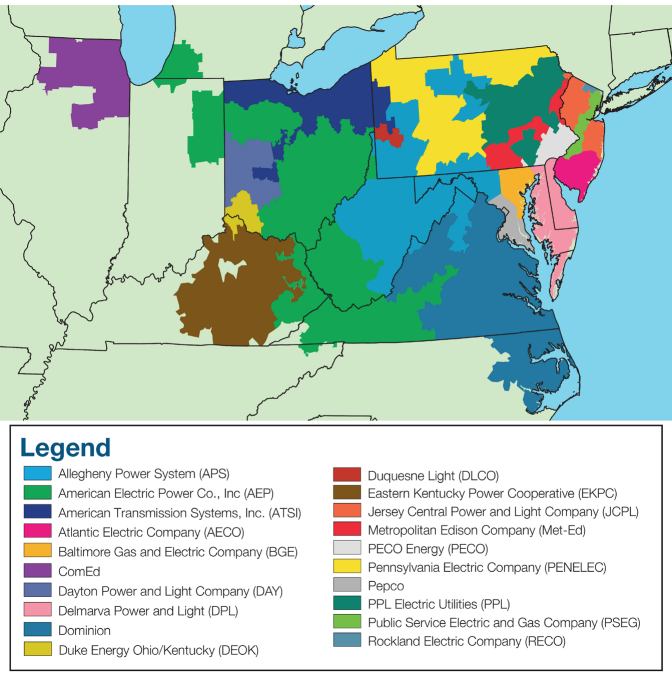

#### Meteostat Weather Data

As an experiment, we also imported in historical temperature data into our model. This data is imported for each hour in a sample region (in this analysis, we utilize Atlantic City).

Data is retrieved using the Meteostat API.

### Approach

Our intention is
This project will utilize time series analysis techniques to model electricity consumption. Our data is split training and test segments, and where feasible, also split into validation segments.

This approach allows for the evaluation of the model's performance over a typical forecasting horizon used in trading scenarios, specifically targeting a 7-day forecast period.

This report will proceed to detail the data preprocessing steps, feature engineering, model selection, and the results of the forecasting models.

---

## What Differentiates Our Work

Our approach is unique in several ways:
1. We forecast out over a large window of time
  * Many other approaches focus entirely on forecasting out 1 hour into the future
  * This is more challenging since it requires shaping our input and output data carefully for each model
  * It also takes substantially more computational power to train a model forecasting on so much data
2. We compare multiple techniques, including models built using Prophet, LSTMs and XGBoost
  * This required attention on the training and testing process to ensure models were comparable
3. Experimentation with temperature data
  * Air temperature data is imported in externally and added as a feature to our dataset
  * This is intended to see if historical air temp trends provide any information useful to forecasting demand

## EDA and Predictions

The PJME dataset has 145,362 unique rows. There are two columns - PJME_MW (float64 representing Megawatts), and Datetime (hourly datetime object). The data is from 2002-01-01 01:00:00 hourly until 2018-08-03 00:00:00.

| PJME_MW | Datetime |
| ------|-----|
| float64  | datetime  |

Data preparation involved cleaning the PJME dataset by making sure all datetime values were datetime objects, removing duplicates, and interpolating missing values. This pre-processing step is essential for ensuring the model is being trained and tested on a continuous time series.

An analysis of the PJME dataset showed a mean that was greater than the median, suggesting right-skewed data. Outliers were largely above the mean rather than below. Graphs on energy use and a right-skewed histogram confirm extreme, seemingly cyclical spikes in consumption.


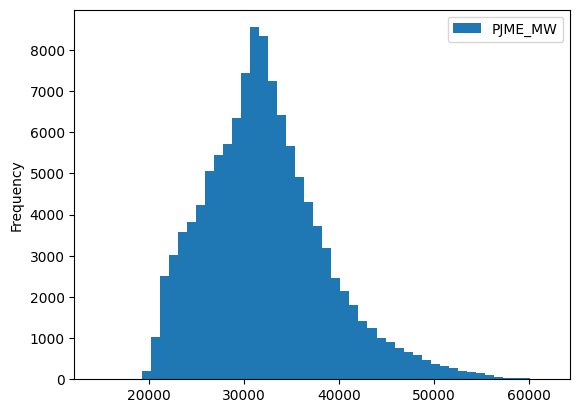

To investigate what causes these spikes, a more in-depth analysis was conducted on the dataset after decomposing the datetime column into hour, day, day of week, day of year, week (of year), month (of year), year, and quarter -- all integer values. Intuitively, these individual columns matter given noticeable patterns in plotted energy use over time.


Trend and seasonal affects were checked for using an ADF unit root test and KPSS test on the time series data. Both reported that the data is stationary, so modeling behavior over time should give consistent results.


Boxplots on MW consumption by each of the created time features show obvious trends by month, week, day of the week, and hour of the day. Seasonality is obvious in boxplot MW by month of year, with peaks energy use in the summer months of June, July, and August. There is a similar pattern in the boxplot for MW by week of year. The boxplot for MW by hour of day also has a pattern that dips in the very early morning hours and peaks in the early evening, which makes sense given the usual working household's habits.

<b>Given the above analysis, we predicted that month, weekday, and hour will have the strongest effect in models.</b>
<br>Given the strong seasonality implied by this, we also expect the incorporation of temperature data to result in more effective models.


The temperature data was requested from the National Oceanic and Atmospheric Administration (NOAA) and the data extracted into two columns: datetime (hourly datetime object, same as the PJME dataset), and temperature in Fahrenheit. This data was also prepared in a similar manner to the PJME one. The power and temperature data was also standardized before combination.

Plotting MW with air temperature produced an expected "duck" curve, which shows peaks at the start and end of the day with a deep valley in between.


## Design Choices

We retrofitted the XGBoost model to work with timeseries data and output predictions for multiple data points simultaneously. We flattened the output arrays into one dimension to fit with sklearn's XGBoost model.

The usual 80%/20% split of train/test data was used for each model.

With exception to the Prophet model, each model was fed 14 days of historical data, with a target of predicting the next 7 days of load.

We trained the models on the first 80% of our data (roughly 2002 to 2015) and tested performance on the remaining 20% of our data (2015 to 2018). Training our models through validation testing was also performed on a seperate project file, leading us to discover the specific hyperparameters used in our project.

Our primary goal was to explore the performance differences in various different models.


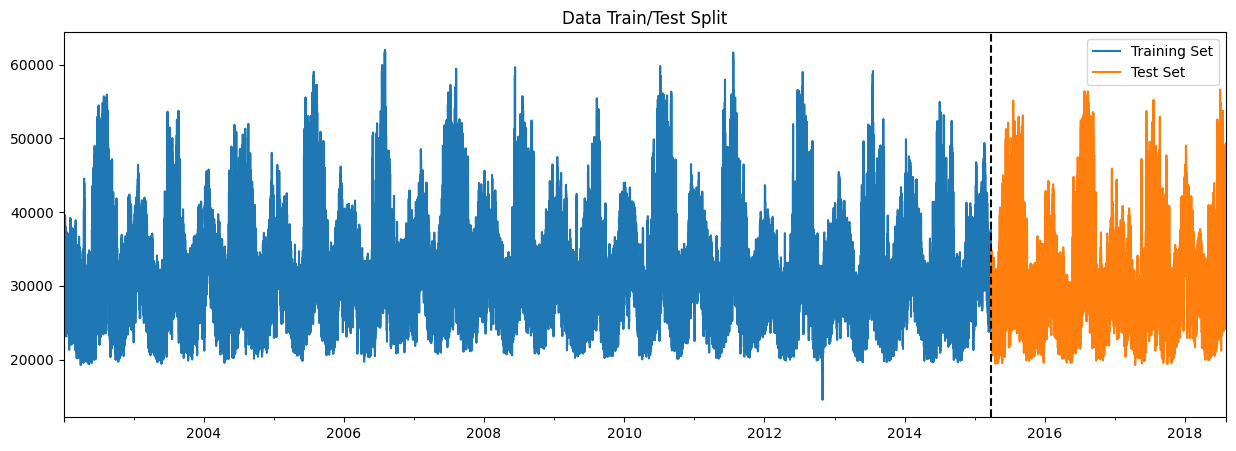


## Results and Insights

Our evaluation metric is the root mean square error (RMSE) and the mean correlation score R². This is computed as the average across all predictions over the test data. This includes predictions starting from 1 hour going up to 7 days into the future.

We also report on runtime we experienced training these models, which was done using Google Colab L4 GPU.

Overall results are summarized below:

| Model             | R² Score | RMSE    | Wall Time | CPU Time |
| ------            |-----     |-------- |--------|--------|
1. Prophet          | 0.5937   | 4135.36 | 1m 46s | 10.6s
2. LSTM             | 0.6593   | 3782.63 | 12m 36s | 14m 32s
3. LSTM + temp data | 0.6631   | 3761.12 | 12m 42s | 14m 40s
4. XGBoost          | 0.6912   | 3601.90 | 6m 6s | 1h 35m

The best results on test data came from the XGBoost model with a mean R² of 0.68. It also trained more quickly than the neural networks, making it the best overall performer. The LSTM neural network with just PJME data had a mean R² of 0.59 and was slow to train. The temperature-supplemented LSTM neural network had a mean R² of __ and performed very closely to the pure LSTM. Both neural networks trained for 20 epochs. The Prophet model performed the worst at R² = 0.59, though it was easiest to implement.

The decay of R² scores by hour had a similar trend across the models. R² scores start at 0.8 and above and deterioriate, with notable dips in score around the 24 hour mark. Interestingly, the R² score for the pure LSTM model goes up and down a few times after 50 hours. XGBoost had the smoothest curve in contrast to this.


### Model #1 - Prophet

#### Introduction
We selected Facebook's open-source forecasting tool, [Prophet](https://facebook.github.io/prophet/), to establish a baseline for our analysis. Prophet is well-regarded for its ease of use and efficiency in handling time-series data, making it an ideal choice for initial comparisons with more complex machine learning models. Its implementation in Python is straightforward and computationally efficient, typically requiring less than two minutes to train on our dataset.

#### Model Implementation
Prophet operates by decomposing time series data into components that represent the underlying trend and seasonality. This decomposition allows the model to handle a wide range of time series patterns with robust performance across different scenarios.

- **Data Input**: Our dataset spans from 2002 to 2018, with the initial period from 2002 to 2015 used for training the model. The subsequent years from 2015 to 2018 serve as our testing period, where we evaluate the model's forecasting capabilities.
- **Training Details**: The model is trained on the entire dataset from 2002 to 2015 without additional feature engineering, relying solely on the datetime and power consumption (MW) values.

#### Forecasting and Performance
In testing, Prophet generated forecasts that matched the general patterns observed in the actual data:
- **Forecast Characteristics**: The model produced forecasts that essentially repeat on a yearly cycle. While this approach captures the long-term trends and seasonal patterns effectively, it struggles to model shorter-term fluctuations, which are critical in high-resolution forecasting tasks.
- **Evaluation Metrics**: The performance of Prophet on our test set resulted in an R² of 0.5937. This score, while modest, reflects the model's capability to capture the macro trends but highlights its limitations in adapting to more dynamic changes within the dataset.

#### Limitations and Future Work
The primary limitation observed with Prophet in our context is its inability to effectively capture short-term variations, which are often driven by more complex dynamics than those captured by seasonal and trend components alone.

- **Future Enhancements**: To improve forecasting accuracy, future iterations could incorporate additional regressors into Prophet, such as weather conditions or economic indicators, which might explain some of the short-term variations in energy consumption.
- **Comparative Analysis**: Continuing to use Prophet as a baseline is valuable for benchmarking more complex models, ensuring that any additional complexity provides a commensurate improvement in performance.

#### Conclusion
Prophet serves as a robust baseline model, offering quick training times and decent predictive performance with minimal tuning required. It provides a solid foundation for comparing more sophisticated machine learning approaches, guiding further enhancements in our predictive modeling efforts.


# Prophet model forecast vs. actual (test period from 2015 to 2018)
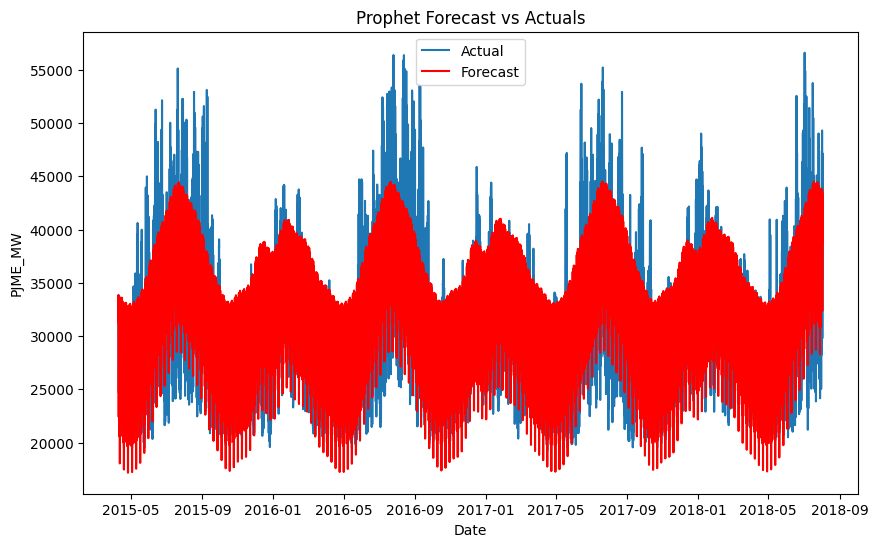

### Model #2 - LSTM (Long Short Term Memory Network)

#### **Model Architecture**
Our second model leverages an LSTM neural network. This network comprises two LSTM layers:
- **Layer Configuration**: Two LSTM layers are used to enhance the model’s ability to learn complex patterns in the data. The first layer processes raw time-series data, while the second layer further abstracts the features extracted by the first layer, improving the model's ability to generalize from historical data to future predictions.

#### **Data Preprocessing**
- **Scaling**: A MinMax scaler is applied to normalize the data, facilitating faster convergence during training. This choice is preferred over the Standard Scaler due to the non-normal distribution of our data, which we wish to preserve.
- **Sequence Preparation**: The data is organized into vectors representing the MW values for each timestamp, aiming to predict the subsequent 7 days' MW values based on the past 14 days.

#### **Regularization and Activation**
- **Dropout**: A 20% dropout rate is employed between each LSTM layer to mitigate overfitting—a challenge we consistently encountered without this regularization.
- **Activation Function**: The `tanh` activation function is utilized, as it helps avoid the gradient explosions often caused by the `ReLU` function in this specific context.

#### **Network Configuration**
- The architecture features 50 neurons in the first layer and 16 in the second, a configuration that worked well when testing using k-folds validation. While this setup was effective, optimizing the number of neurons through a systematic grid search in future iterations could potentially enhance results.

#### **Performance Evaluation**
- **Metric Results**: The LSTM model achieved an R² of 0.6593 on the test data, indicative of a decent fit to the observed electricity consumption patterns.
- **Error Analysis**: We observed an increase in the Mean Squared Error (MSE) as predictions extended further into the future, with the R² value inversely decreasing. This trend underscores the inherent challenge in using historical data for long-range forecasting, where the predictive power diminishes as the forecast horizon extends.

#### **Visual Analysis**
- A plot of the model's performance over forecasted hours reveals a predictable decline in accuracy with longer forecasts. This visual representation helps validate the quantitative metrics and provides a clear, intuitive understanding of the model's limitations and capabilities.

#### **Conclusion and Future Work**
While the current LSTM model performs adequately, exploring alternative configurations and more extensive hyperparameter tuning could yield improvements. Additionally, employing advanced techniques like attention mechanisms might enhance the model's ability to focus on more relevant past observations for long-term forecasts.


### Model #2 - LSTM (time only) Performance Plot
* Plots the average MSE and R^2 for model predictions forecasted over 7 day period.

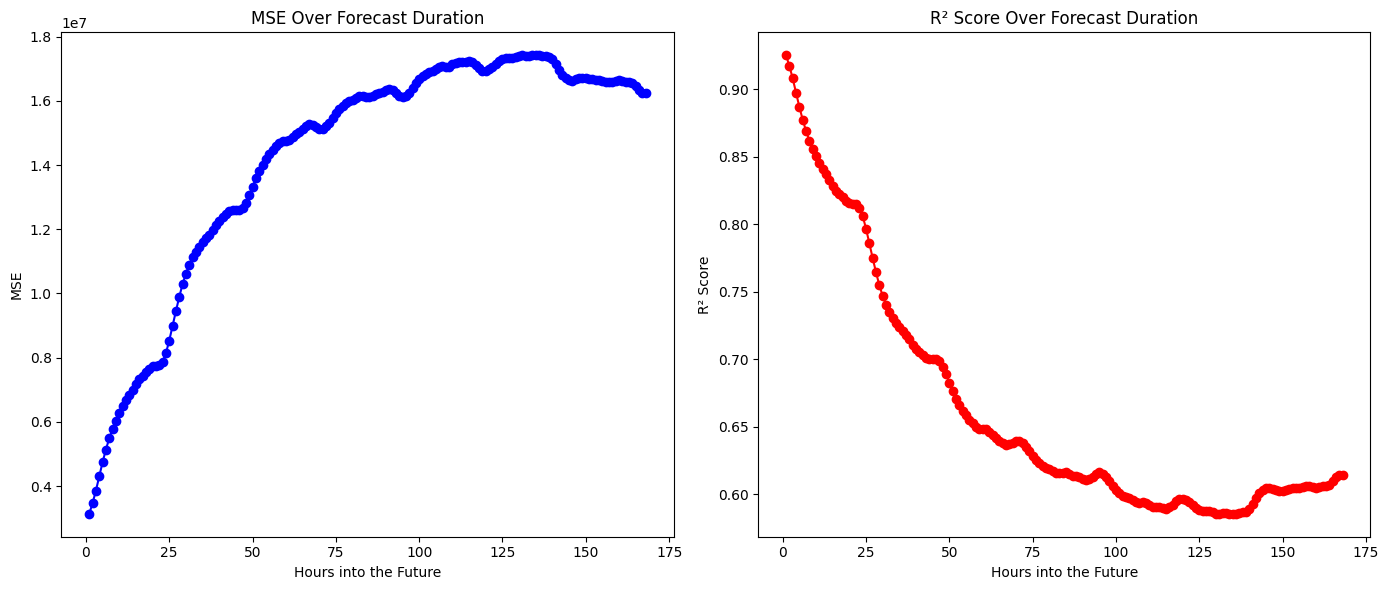

### Model #3 - LSTM (Time + Temperature)

#### Overview
Our third model extends the LSTM architecture used in Model #2 by integrating ambient air temperature data alongside electricity consumption metrics. This model employs a two-layer LSTM structure identical to Model #2 but is adapted to handle multivariate input.

#### Data Integration and Preparation
- **Temperature Data**: Historical hourly temperature data for Atlantic City, NJ, within the PJM Eastern territory, was sourced from [Meteostat](https://meteostat.net/). This selection is based on the premise that regional weather conditions significantly affect energy consumption.
- **Data Synchronization**: Temperature data was synchronized with MW consumption data to create input vectors for the LSTM, each containing two features per timestamp—electricity consumption and corresponding temperature for the previous 14 days.

#### Model Architecture
- **Input Features**: Each input vector consists of data spanning the last 14 days, targeting to predict MW consumption for the subsequent 7 days.
- **Layers Configuration**: The LSTM features a first layer with 50 neurons and a second layer with 16 neurons, using a `tanh` activation function. A 20% dropout rate is applied between layers to mitigate overfitting.

#### Hypothesis Testing and Results
- **Initial Hypothesis**: We posited that including temperature data would enhance the model's predictive accuracy by correlating temperature fluctuations with changes in energy consumption, particularly during periods of extreme temperatures.
- **Analysis and Findings**: Visual analysis of temperature against MW consumption suggested a strong correlation. However, when incorporated into the LSTM model, the temperature data did not significantly improve the predictive performance compared to Model #2, which did not include temperature data. This outcome suggests that while there is a correlation, the temperature data as used did not add predictive value beyond what the LSTM could capture from the MW data alone.


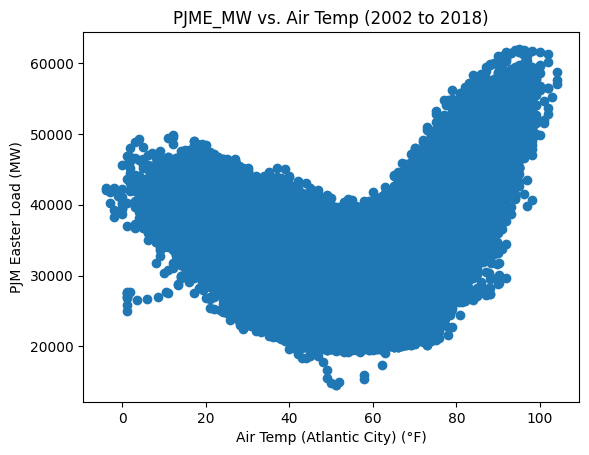

#### Future Directions and Considerations
- **Model Improvement**: Future analysis could explore the integration of forecasted temperature data instead of historical readings, hypothesizing that predictive temperature patterns might offer novel insights for forecasting energy consumption.
- **Data Challenges**: Extracting and utilizing forecasted temperature data presents logistical challenges, as historical forecasts are not readily available and might require different data sourcing strategies or partnerships with meteorological agencies.

#### Conclusion
While the inclusion of temperature data in our LSTM model did not yield the anticipated improvements in predictive performance, it provided valuable insights into the complex dynamics of energy consumption modeling. Future iterations will focus on enhancing data integration and exploring alternative predictive features that might yield more substantial improvements.

#### Model #3 - LSTM (time + temp) Performance Plot
* Plots the average MSE and R^2 for model predictions forecasted over 7 day period.
* Preformance is very similar to LSTM model without temperature

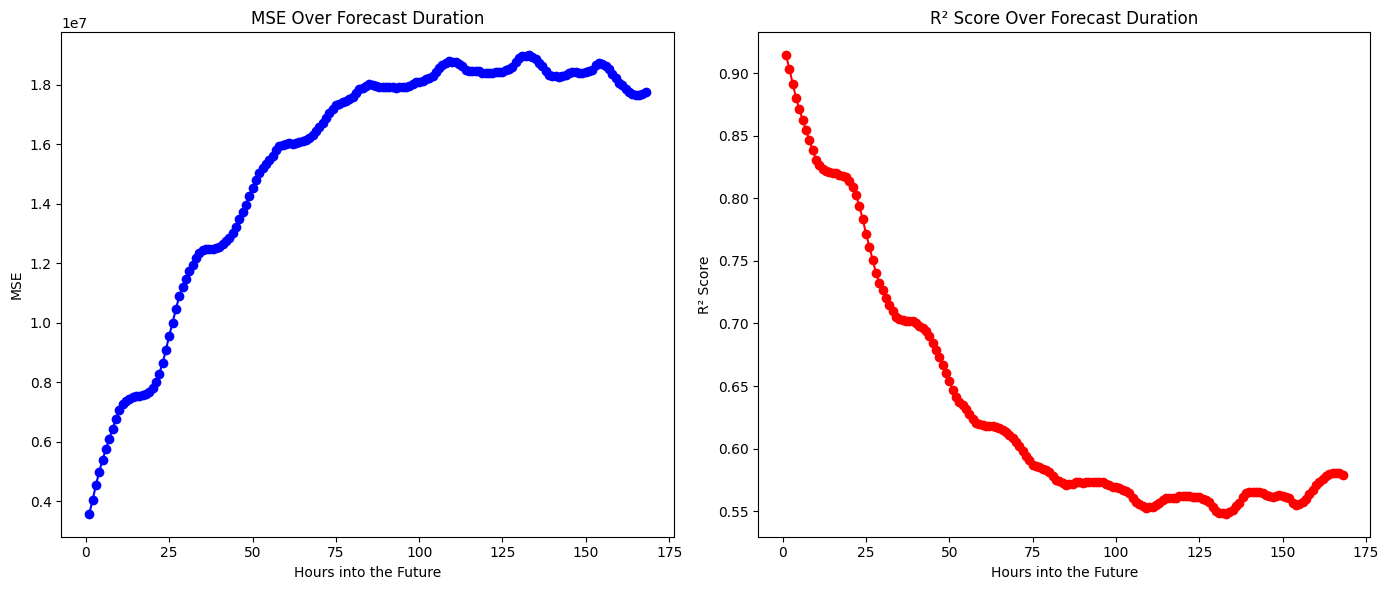

### Model #4 - XGBoost

#### Overview
Our fourth model utilizes XGBoost, a powerful and widely used machine learning algorithm known for its speed and performance, particularly in competitive machine learning competitions. XGBoost excels in regression tasks due to its robust handling of various types of features and its ability to model complex nonlinear relationships.

#### Data Preparation and Feature Engineering
- **Feature and Target Construction**: The model uses the past 14 days of hourly electricity consumption data to predict the next 7 days. This involves input vectors of 336 hours and output vectors of 168 hours.
- **Data Transformation**: Like before, we applied a MinMax scaler to the electricity consumption data to normalize the range and enhance model convergence.

#### Model Training and Configuration
- **Model Architecture**: We configured the XGBoost model with 100 estimators and a maximum depth of 3. This setup was chosen to balance between model complexity and training efficiency. Given the runtime, it was not feasible to test other configurations.
- **Training Process**: The model was trained on 80% of the data, with the remaining 20% used for testing. The focus during training was on minimizing the root mean squared error (RMSE), which is a common measure for regression tasks.

#### Performance Evaluation
- **Execution Time**: The model required approximately 1 hour and 35 minutes to train (CPU time), reflecting the substantial computational demand due to the high granularity and volume of data.
- **Model Accuracy**: With an R² of 0.6912 on the test dataset, the model demonstrated a strong ability to capture and predict patterns in electricity consumption.

#### Grid Search
- Grid search was implemented on another variant of the selected model, using a search space of 50 or 200 estimators, and a max depth of 3 or 7
- The optimal model selected had max_depth of 3 and 200 estimators
- Data was split into 70% training data, 20% validation data, and 10% testing data
- The grid search took several hours to execute
- Interestingly, the "best model" discovered had worse performance statistics than our initial XGBoost model (100 estimators and max depth of 3) with only an R^2 value of 0.61 vs. base model R^2 of 0.69
- Code is listed at end of report for demonstration purposes (note long execution time expected)

#### Conclusion
The XGBoost model was both the best performance wise, but also the most expensive to train. XGBoost is not often used for outputing forecast data like this, so it was interesting to see how it performed. While decent, the training time is too expensive to consider using this model in the future. Also found grid search over this large data set was impractically long.

# Model #4 - XGBoost
* Plots the average MSE and R^2 for model predictions forecasted over 7 day period.
* Preformance is the best amongst the models we tested


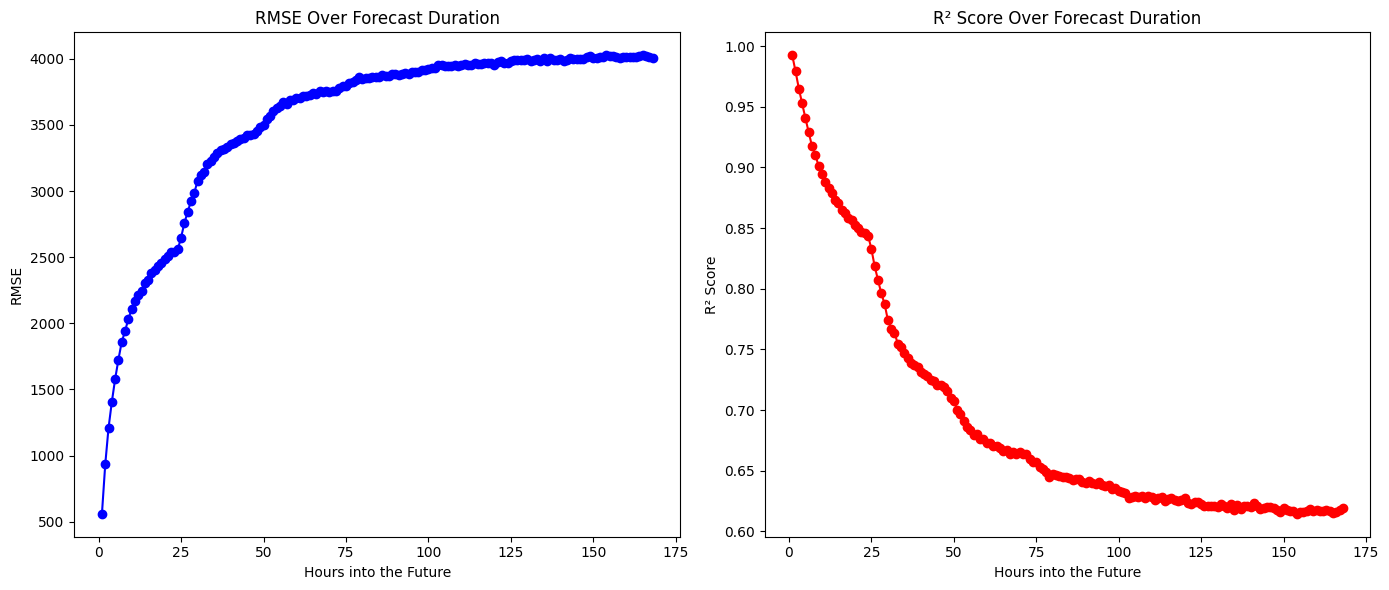

### XGBoost actual vs. predicted values for first 7 days of data
# Output based on grid search model

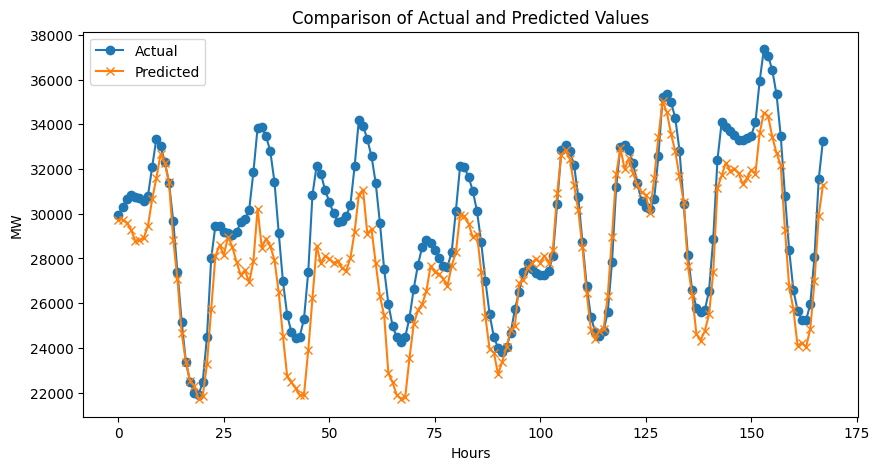

## Conclusions and Future Opportunities

### Summary of Achievements
This project successfully developed and compared several predictive models using the PJM Hourly Energy Consumption data. Key achievements include:
- **Effective Model Development**: Models ranging from traditional time series (Prophet) to advanced machine learning techniques (LSTM and XGBoost) were implemented and assessed.
- **Incorporation of External Data**: Temperature data from Meteostat was integrated to explore its impact on forecasting accuracy.


### Key Findings
- **XGBoost's Superior Performance**: The XGBoost model outperformed others in terms of accuracy with an R² of 0.6912, although it required the longest training time.
- **Grid Search Issues**: Our implementation of grid search using k-fold validation took a significant amount of time, and did not discover improved model performance - this suggests some caution should be taken when implementing grid search on large datasets
- **Limited Impact of Temperature Data**: Including temperature data did not significantly enhance the LSTM model’s performance, indicating that the electricity consumption data alone provided sufficient predictive power for the model frameworks used.
- **Scalability and Efficiency Concerns**: The extensive computational resources required by models, especially XGBoost, highlighted potential scalability and efficiency challenges for operational use.

### Future Directions
- **Advanced Feature Engineering**: Exploring more sophisticated feature engineering techniques and incorporating additional predictors like weather forecasts could further improve model accuracy.
- **Model Optimization**: Systematic hyperparameter tuning and exploration of different model architectures could yield better performance and efficiency.
- **Cross-Validation Implementation**: Employing cross-validation techniques to assess model robustness and avoid overfitting, especially for models with significant training times like XGBoost.

### Final Thoughts
Model development is hard! This project has made it clear that having a good foundation in machine/deep learning is essential. It's not possible to search the entire hyperspace of potential models, so you need to know where to start and how to make the appropriate manual corrections. Our team appreciates the opporutnity to present this project, and get our hands in real world data.


In [ ]:
!pip install tensorflow
!pip install meteostat
!pip install prophet

In [ ]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import sklearn.preprocessing

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM
from tensorflow.keras.models import Sequential
from meteostat import Hourly, Stations
from datetime import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# PJM East Region: 2001-2018 (PJME)
# estimated energy consumption in Megawatts (MW)
# https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption?select=PJME_hourly.csv
file_path = '/content/drive/My Drive/Additional Education/NJIT/Classes/DS675-854 Machine Learning/Project/data/pjm/PJME_hourly.csv'

pjme_data = pd.read_csv(file_path)


In [ ]:
import pandas as pd

def clean_time_series_data(df):
    """
    Cleans the provided DataFrame by setting the datetime column as index,
    removing duplicates, and interpolating missing data.

    Parameters:
    - df: pandas.DataFrame, the DataFrame to clean.

    Returns:
    - pandas.DataFrame, cleaned time series data.
    """
    # Convert datetime column to datetime type if not already
    df["Datetime"] = pd.to_datetime(df["Datetime"])

    # Set the datetime column as the index
    df.set_index("Datetime", inplace=True)

    # Remove duplicates
    df = df[~df.index.duplicated(keep='first')]

    # Generate a complete datetime range
    full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')

    # Reindex the DataFrame to include all hourly intervals
    df = df.reindex(full_range)

    # Interpolate missing values linearly
    df.interpolate(method='linear', inplace=True)

    return df


In [ ]:
pjme_data = clean_time_series_data(pjme_data)

# Model #1 - Prophet
* How model works: We utilizes a simple Prophet model that takes the training period in as an input (2002 to 2015) and predicts the MW values for the subsequent test period (2015 to 2018)
* Performance metrics of model:
* MSE: 17101227.65
* RMSE: 4135.36
* R2 Score: 0.5937

In [ ]:
# Make a distinct copy of data to use for prophet model
prophet_data = pjme_data.copy()

In [ ]:
prophet_data["ds"] = prophet_data.index
prophet_data["y"] = prophet_data["PJME_MW"]

# Split data into train and test sets
split_point = int(0.8 * len(prophet_data))


In [ ]:
# Split the data into training and testing sets
prophet_train_data = prophet_data.iloc[:split_point]
prophet_test_data = prophet_data.iloc[split_point:]

In [ ]:
# Create prophet model using the training data

prophet_model = Prophet(interval_width=0.80)
%time prophet_model.fit(prophet_train_data)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpp1v_ex5b/5hehmk_y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp1v_ex5b/0k0n2axn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14280', 'data', 'file=/tmp/tmpp1v_ex5b/5hehmk_y.json', 'init=/tmp/tmpp1v_ex5b/0k0n2axn.json', 'output', 'file=/tmp/tmpp1v_ex5b/prophet_modelq7vqz_v3/prophet_model-20240425014046.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:42:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 10.3 s, sys: 352 ms, total: 10.6 s
Wall time: 1min 45s


In [ ]:

start_date = prophet_test_data.index.min()
end_date = prophet_test_data.index.max()

# Calculate the number of hours between the last train date and the last available date
forecast_horizon = (end_date - start_date).total_seconds() / 3600  # convert seconds to hours

# Adjust this to an integer if needed (though it should already be an integer if data are hourly)
forecast_horizon = int(forecast_horizon)

# Create a future dataframe that covers the test data range
future_dates = prophet_model.make_future_dataframe(periods=forecast_horizon, freq='H')


In [ ]:
# Predict over the future dataframe
prophet_forecast = prophet_model.predict(future_dates)

# Display the forecast; you might want to join this with the actual values to compare performance
prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2002-01-01 01:00:00,25696.865183,21093.003526,30601.648604
1,2002-01-01 02:00:00,24232.401260,19743.316136,28461.604060
2,2002-01-01 03:00:00,23389.839301,19184.718416,28142.052106
3,2002-01-01 04:00:00,23269.921211,18575.553291,27750.394557
4,2002-01-01 05:00:00,23963.685522,19460.501343,28781.986995


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


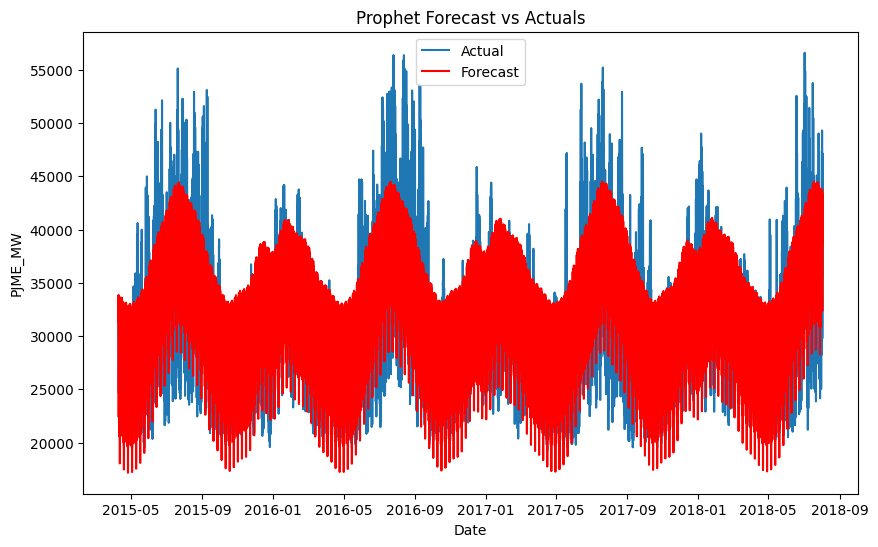

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Assuming test_data is prepared with a 'Datetime' index and a single target column 'PJME_MW'
prophet_test_data['forecast'] = prophet_forecast.set_index('ds')['yhat'].reindex(prophet_test_data.index)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(prophet_test_data["ds"], prophet_test_data['PJME_MW'], label='Actual')
plt.plot(prophet_test_data["ds"], prophet_test_data['forecast'], color='r', label='Forecast')
plt.title('Prophet Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('PJME_MW')
plt.legend()
plt.show()




In [ ]:
# Calculate RMSE and R2
def get_prophet_model_performance():
  mse = mean_squared_error(prophet_test_data.dropna()['PJME_MW'], prophet_test_data.dropna()['forecast'])
  rmse = np.sqrt(mse)
  r2 = r2_score(prophet_test_data.dropna()['PJME_MW'], prophet_test_data.dropna()['forecast'])
  print(f'MSE: {round(mse,2)}')
  print(f'RMSE: {round(rmse,2)}')
  print(f'R2 Score: {round(r2,4)}')

get_prophet_model_performance()

MSE: 17101227.65
RMSE: 4135.36
R2 Score: 0.5937


# Model #2 - LSTM (time only)
* How model works:
* Performance metrics of model:
  * Mean Squared Error: 14308318.056305274
  * Mean Squared Error: 3782.633745990388
  * R² Score: 0.6593637771419646

In [ ]:
# Normalize the feature(s)
mw_scaler = MinMaxScaler()
pjme_data['scaled'] = mw_scaler.fit_transform(pjme_data[['PJME_MW']].values)

In [ ]:
def create_sequences(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data[i:(i + n_steps_in), 0])
        y.append(data[(i + n_steps_in):(i + n_steps_in + n_steps_out), 0])
    return np.array(X), np.array(y)

# Example settings
n_steps_in, n_steps_out = 24*14, 24*7  # Use 14 days to predict the next 7 days

# Reshape the dataset suitable for the LSTM model
dataset = pjme_data['scaled'].values.reshape(-1, 1)


# Create the sequences
X, y = create_sequences(dataset, n_steps_in, n_steps_out)

# Split data into train and test sets
split_point = int(0.8 * len(X))
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

# Reshape data for LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [ ]:
model = Sequential()
# First LSTM layer with dropout
model.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=(n_steps_in, 1))) # Used tanh activation function due to convergence issues with reLU
model.add(Dropout(0.2))  # Adding 20% dropout to prevent overfitting

# Second LSTM layer
model.add(LSTM(16, activation='tanh'))  # Used tanh activation function due to convergence issues with reLU
model.add(Dropout(0.2))  # Adding 20% dropout to prevent overfitting

# Output layer
model.add(Dense(n_steps_out))

model.compile(optimizer='adam', loss='mse')

In [ ]:
# Fit the model
%time history = model.fit(X_train, y_train,epochs=20, batch_size=64, validation_split=0.1, verbose=1)


Epoch 1/20
1630/1630 [==============================] - 40s 22ms/step - loss: 0.0159 - val_loss: 0.0075
Epoch 2/20
1630/1630 [==============================] - 33s 20ms/step - loss: 0.0079 - val_loss: 0.0069
Epoch 3/20
1630/1630 [==============================] - 33s 20ms/step - loss: 0.0071 - val_loss: 0.0064
Epoch 4/20
1630/1630 [==============================] - 33s 20ms/step - loss: 0.0066 - val_loss: 0.0053
Epoch 5/20
1630/1630 [==============================] - 33s 20ms/step - loss: 0.0062 - val_loss: 0.0053
Epoch 6/20
1630/1630 [==============================] - 32s 20ms/step - loss: 0.0061 - val_loss: 0.0056
Epoch 7/20
1630/1630 [==============================] - 32s 20ms/step - loss: 0.0060 - val_loss: 0.0055
Epoch 8/20
1630/1630 [==============================] - 32s 20ms/step - loss: 0.0059 - val_loss: 0.0052
Epoch 9/20
1630/1630 [==============================] - 33s 20ms/step - loss: 0.0058 - val_loss: 0.0054
Epoch 10/20
1630/1630 [==============================] - 32s 20m

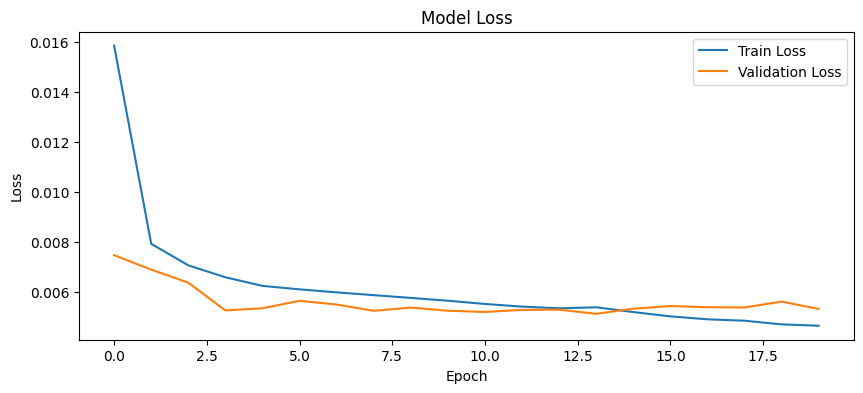

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [ ]:
y_pred = model.predict(X_test)

906/906 [==============================] - 8s 9ms/step


In [ ]:
# Reshape y_pred and y_test to fit scaler's expected shape
y_pred_rescaled = mw_scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = mw_scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# If y_test was reshaped during preprocessing, reshape it back for metrics calculation
y_pred_rescaled = y_pred_rescaled.reshape(y_pred.shape)
y_test_rescaled = y_test_rescaled.reshape(y_test.shape)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print("Mean Squared Error:", mse)
print("Mean Squared Error:", rmse)
print("R² Score:", r2)


Mean Squared Error: 14448062.929273833
Mean Squared Error: 3801.060763691345
R² Score: 0.656044355702725


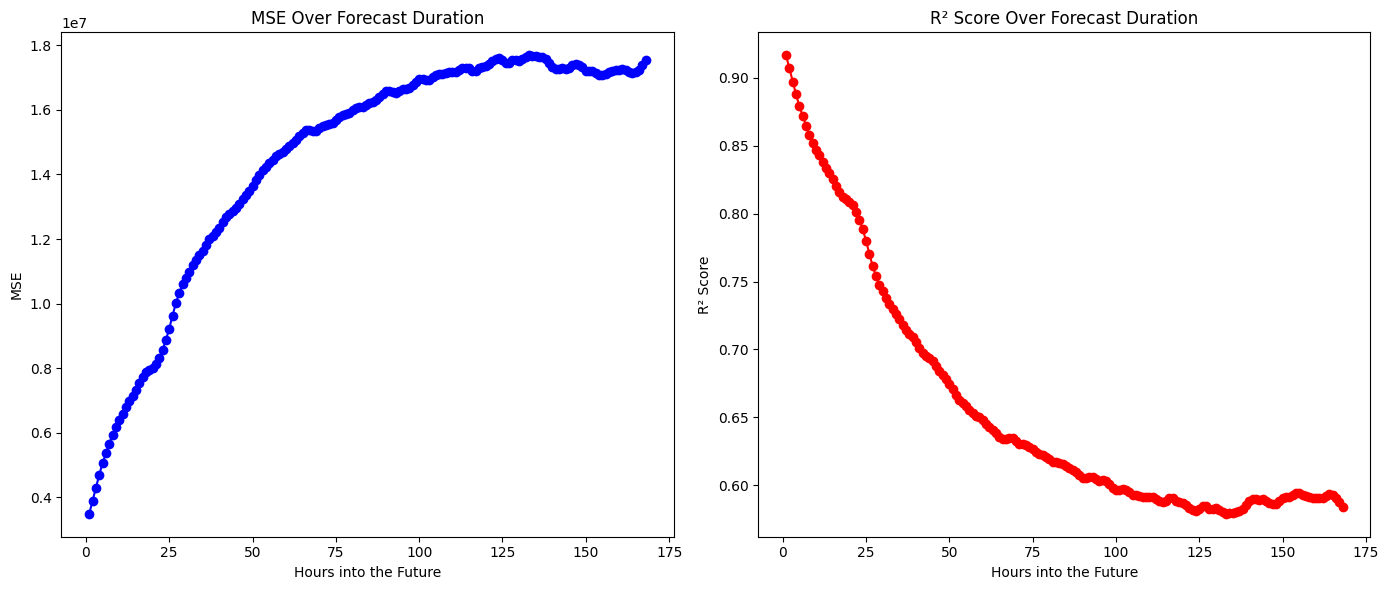

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate MSE and R2 for each forecast hour
mse_scores = [mean_squared_error(y_test_rescaled[:, i], y_pred_rescaled[:, i]) for i in range(y_pred_rescaled.shape[1])]
r2_scores = [r2_score(y_test_rescaled[:, i], y_pred_rescaled[:, i]) for i in range(y_pred_rescaled.shape[1])]

# Plotting the results
hours = np.arange(1, y_pred_rescaled.shape[1] + 1)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(hours, mse_scores, marker='o', linestyle='-', color='b')
plt.title('MSE Over Forecast Duration')
plt.xlabel('Hours into the Future')
plt.ylabel('MSE')

plt.subplot(1, 2, 2)
plt.plot(hours, r2_scores, marker='o', linestyle='-', color='r')
plt.title('R² Score Over Forecast Duration')
plt.xlabel('Hours into the Future')
plt.ylabel('R² Score')

plt.tight_layout()
plt.show()


# Model #3 - LSTM (time + historical temp)
* How model works:
* Performance metrics of model:
  * Aggregate Mean Squared Error: 14146080.254972203
  * Aggregate Root Mean Squared Error: 3761.127524422989
  * Aggregate R² Score: 0.6631397323886495

In [ ]:
def find_stations_by_location(locations):
    stations_info = {}

    for utility, loc in locations.items():
        # Find nearby weather stations
        stations = Stations()
        stations = stations.nearby(loc['latitude'], loc['longitude'])
        station = stations.fetch(1)  # Fetch top station

        if not station.empty:
            # Assume the first station is the closest
            stations_info[utility] = station.iloc[0].to_dict()

    return stations_info

# Dictionary mapping utility names to their representative city's latitude and longitude
locations = {
    'AP': {'city': 'Atlantic', 'latitude': 39.3766109, 'longitude': -74.452823},
    'JCPL': {'city': 'Lakehurst', 'latitude': 40.0128848, 'longitude': -74.354106},
    'PSEG': {'city': 'Newark', 'latitude': 40.7330124, 'longitude': -74.279225},
    'DPL': {'city': 'Salisbury', 'latitude': 38.377498, 'longitude': -75.6313444},
    'PECO': {'city': 'Philadelphia', 'latitude': 40.0026438, 'longitude': -75.2831798},
    'PPL': {'city': 'Allentown', 'latitude': 40.5931353, 'longitude': -75.5251054},

}

stations_info = find_stations_by_location(locations)

In [ ]:
def get_weather_features(location):
    # Prepare an empty DataFrame to hold all weather data
    weather_features = pd.DataFrame()

    # Get lat and lot
    latitude = location['latitude']
    longitude = location['longitude']

    # Find the nearest station
    stations = Stations()
    stations = stations.nearby(latitude, longitude)
    station = stations.fetch(1)

    # Get hourly data for the station
    start = min(pjme_data.index)
    end = max(pjme_data.index)
    weather_data = Hourly(station['wmo'][0], start, end)
    weather_data = weather_data.fetch()

    # Convert temperature to Fahrenheit
    weather_data['temp'] = weather_data['temp'] * 9/5 + 32
    weather_data = weather_data[['temp']]

    # Generate a complete datetime range
    full_range = pd.date_range(start=weather_data.index.min(), end=weather_data.index.max(), freq='H')

    # Reindex the DataFrame to include all hourly intervals
    weather_data = weather_data.reindex(full_range)

    # Interpolate missing values linearly
    weather_data.interpolate(method='linear', inplace=True)


    return weather_data


In [ ]:
weather_data = get_weather_features(locations['AP'])
weather_data.head()

,temp
2002-01-01 01:00:00,24.8
2002-01-01 02:00:00,24.8
2002-01-01 03:00:00,22.1
2002-01-01 04:00:00,19.4
2002-01-01 05:00:00,19.4


Text(0.5, 1.0, 'PJME_MW vs. Air Temp (2002 to 2018)')

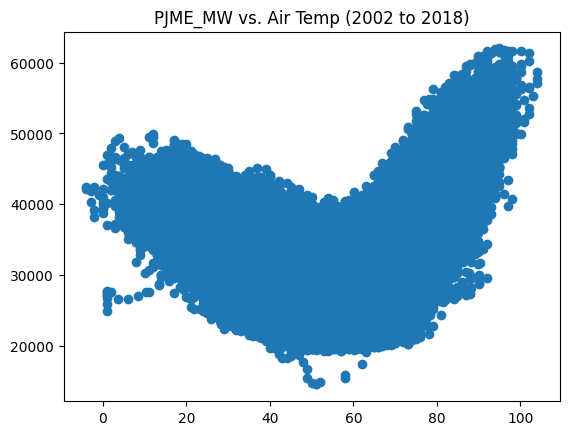

In [ ]:
plt.scatter(weather_data['temp'], pjme_data['PJME_MW'])
plt.title("PJME_MW vs. Air Temp (2002 to 2018)")

In [ ]:
# Normalize the feature(s)
pjme_scaler = MinMaxScaler()
pjme_data['scaled'] = pjme_scaler.fit_transform(pjme_data[['PJME_MW']].values)

weather_scaler = MinMaxScaler()
weather_data['temp_scaled'] = weather_scaler.fit_transform(weather_data[['temp']])


In [ ]:
# Combine the scaled features into one dataframe
combined_data = pd.DataFrame(index=pjme_data.index)
combined_data['power_scaled'] = pjme_data['scaled']
combined_data['temp_scaled'] = weather_data['temp_scaled']

# Drop any rows with NaN values that may have resulted from alignment
combined_data.dropna(inplace=True)


In [ ]:
def create_multivariate_sequences(input_data, output_data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(n_steps_in, len(input_data) - n_steps_out + 1):
        X.append(input_data[i - n_steps_in:i])  # Input sequence with both features
        y.append(output_data[i:i + n_steps_out])  # Output sequence with only PJME_MW
    return np.array(X), np.array(y)

# 'power_scaled' is the feature to be predicted
input_dataset = combined_data[['power_scaled', 'temp_scaled']].values
output_dataset = combined_data['power_scaled'].values.reshape(-1, 1)

n_features = combined_data.shape[1]  # number of features, 2 in this case (power and temperature)

n_steps_in, n_steps_out = 24*14, 24*7  # Use previous 14 days to predict the next 7 days

# Create the sequences with both features for X and only power_scaled for y
X, y = create_multivariate_sequences(input_dataset, output_dataset, n_steps_in, n_steps_out)

# Now, split the data into train and test sets as before
split_point = int(0.8 * len(X))
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

# Reshape data for LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))


In [ ]:
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
# First LSTM layer with dropout
model.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=(n_steps_in, n_features))) # Used tanh activation function due to convergence issues with reLU
model.add(Dropout(0.2))  # Adding 20% dropout to prevent overfitting

# Second LSTM layer
model.add(LSTM(16, activation='tanh')) # Used tanh activation function due to convergence issues with reLU
model.add(Dropout(0.2))  # Adding 20% dropout to prevent overfitting

# Output layer
model.add(Dense(n_steps_out))

model.compile(optimizer='adam', loss='mse')

In [ ]:
# Fit the model
%time history = model.fit( X_train, y_train, epochs=20, batch_size=64, validation_split=0.1, verbose=1)


Epoch 1/20
1630/1630 [==============================] - 36s 20ms/step - loss: 0.0155 - val_loss: 0.0075
Epoch 2/20
1630/1630 [==============================] - 32s 20ms/step - loss: 0.0078 - val_loss: 0.0073
Epoch 3/20
1630/1630 [==============================] - 32s 20ms/step - loss: 0.0070 - val_loss: 0.0062
Epoch 4/20
1630/1630 [==============================] - 32s 20ms/step - loss: 0.0066 - val_loss: 0.0057
Epoch 5/20
1630/1630 [==============================] - 32s 20ms/step - loss: 0.0062 - val_loss: 0.0053
Epoch 6/20
1630/1630 [==============================] - 32s 20ms/step - loss: 0.0061 - val_loss: 0.0055
Epoch 7/20
1630/1630 [==============================] - 32s 20ms/step - loss: 0.0060 - val_loss: 0.0052
Epoch 8/20
1630/1630 [==============================] - 32s 20ms/step - loss: 0.0059 - val_loss: 0.0053
Epoch 9/20
1630/1630 [==============================] - 32s 20ms/step - loss: 0.0057 - val_loss: 0.0052
Epoch 10/20
1630/1630 [==============================] - 32s 20m

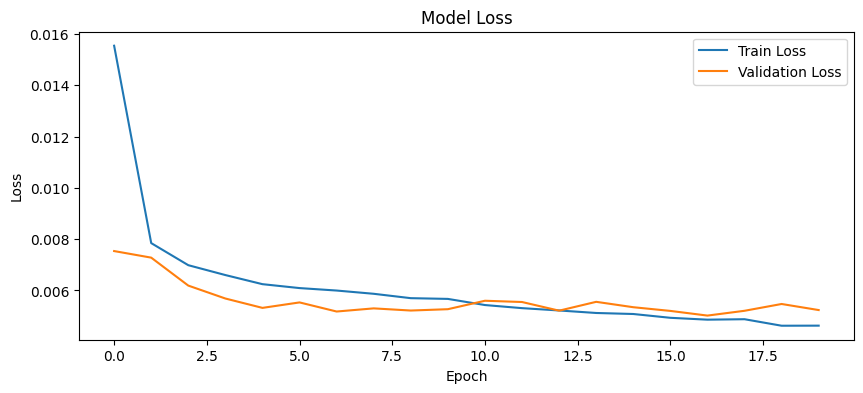

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Predict future values
y_pred = model.predict(X_test)

906/906 [==============================] - 8s 8ms/step


In [ ]:
# Reshape y_pred and y_test to fit scaler's expected shape
y_pred_rescaled_scaler_shape = mw_scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled_scaler_shape = mw_scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# If y_test was reshaped during preprocessing, reshape it back for metrics calculation
y_pred_rescaled = y_pred_rescaled_scaler_shape.reshape(y_pred.shape)
y_test_rescaled = y_test_rescaled_scaler_shape.reshape(y_test.shape)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Compute the Mean Squared Error
mse = mean_squared_error(y_test_rescaled_scaler_shape, y_pred_rescaled_scaler_shape)

# Compute the Root Mean Squared Error
rmse = np.sqrt(mse)

# Compute the R² Score
r2 = r2_score(y_test_rescaled_scaler_shape, y_pred_rescaled_scaler_shape)

print("Aggregate Mean Squared Error:", mse)
print("Aggregate Root Mean Squared Error:", rmse)
print("Aggregate R² Score:", r2)


Aggregate Mean Squared Error: 13484371.856234122
Aggregate Root Mean Squared Error: 3672.10727733193
Aggregate R² Score: 0.6788969785135073


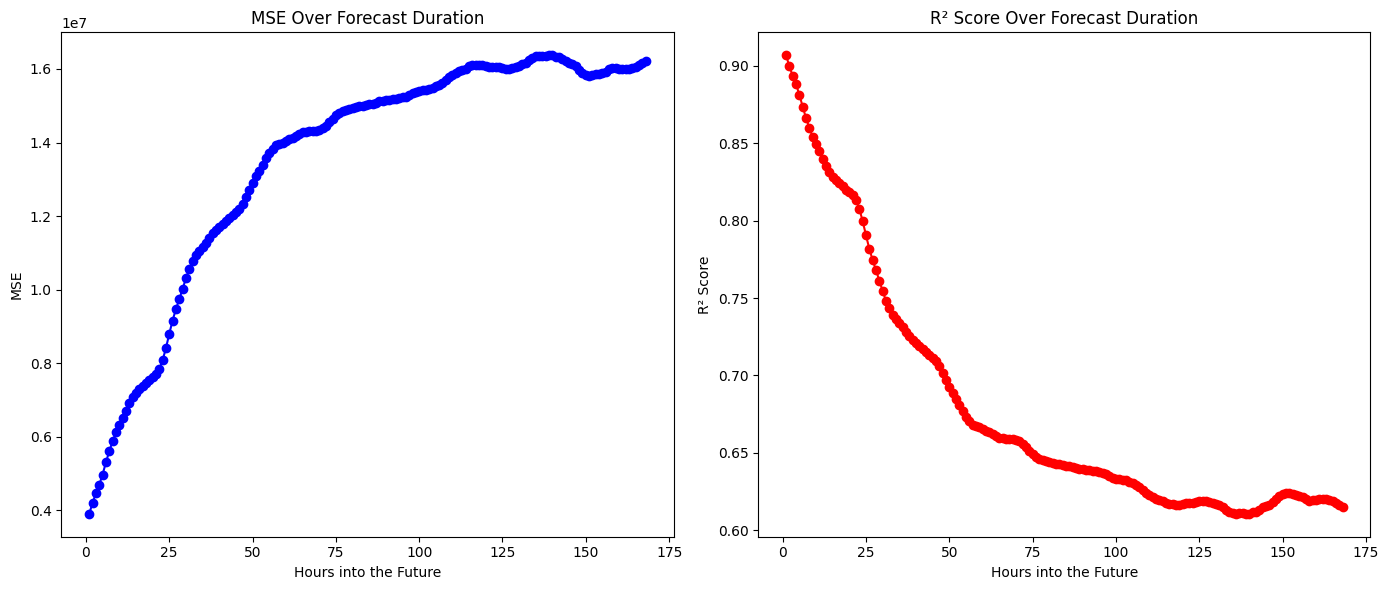

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score


# Calculate MSE and R2 for each forecast hour
mse_scores = [mean_squared_error(y_test_rescaled[:, i], y_pred_rescaled[:, i]) for i in range(y_pred_rescaled.shape[1])]
r2_scores = [r2_score(y_test_rescaled[:, i], y_pred_rescaled[:, i]) for i in range(y_pred_rescaled.shape[1])]

# Plotting the results
hours = np.arange(1, y_pred_rescaled.shape[1] + 1)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(hours, mse_scores, marker='o', linestyle='-', color='b')
plt.title('MSE Over Forecast Duration')
plt.xlabel('Hours into the Future')
plt.ylabel('MSE')

plt.subplot(1, 2, 2)
plt.plot(hours, r2_scores, marker='o', linestyle='-', color='r')
plt.title('R² Score Over Forecast Duration')
plt.xlabel('Hours into the Future')
plt.ylabel('R² Score')

plt.tight_layout()
plt.show()


# Model #4 - XGBoost
* How model works:
* Performance metrics of model:
  * Aggregate Mean Squared Error: 12973694.776688829
  * Aggregate Root Mean Squared Error: 3601.9015501105564
  * Aggregate R² Score: 0.6911604195827705

In [ ]:
# Normalize the feature(s)
scaler = MinMaxScaler()
pjme_data['scaled'] = scaler.fit_transform(pjme_data[['PJME_MW']].values)

In [ ]:
def create_features_targets(data, n_in, n_out):
    """
    data: input dataframe, expected a single column of data
    n_in: number of lag observations as input (X)
    n_out: number of outputs (y)
    """
    X, y = [], []
    for i in range(len(data) - n_in - n_out + 1):
        X.append(data[i:(i + n_in)].values)
        y.append(data[(i + n_in):(i + n_in + n_out)].values)
    return np.array(X), np.array(y)


In [ ]:
# Parameters
n_in = 24 * 14  # 14 days of data, assuming hourly steps
n_out = 24 * 7  # predicting the next 7 days

X, y = create_features_targets(pjme_data['scaled'], n_in, n_out)


In [ ]:
# Split into training and testing sets
split_point = int(0.8 * len(X))
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

In [ ]:
# XGBoost does not natively handle multi-output regression in its sklearn API,
# so we train one model for all outputs at once by flattening the array.

y_train_flat = y_train.reshape(y_train.shape[0], -1)  # Flatten y_train
y_test_flat = y_test.reshape(y_test.shape[0], -1)  # Flatten y_test


In [ ]:
import xgboost as xgb

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3)
%time model.fit(X_train, y_train_flat, eval_metric='rmse', verbose=True)


CPU times: user 1h 15min 5s, sys: 2.33 s, total: 1h 15min 7s
Wall time: 9min 44s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_test

array([[0.27898451, 0.28041715, 0.28585273, ..., 0.29476456, 0.29409038,
        0.29181502],
       [0.28041715, 0.28585273, 0.2868008 , ..., 0.29409038, 0.29181502,
        0.29236279],
       [0.28585273, 0.2868008 , 0.31086063, ..., 0.29181502, 0.29236279,
        0.29377436],
       ...,
       [0.52105762, 0.44660276, 0.38457811, ..., 0.62178447, 0.60490888,
        0.56900874],
       [0.44660276, 0.38457811, 0.34189403, ..., 0.60490888, 0.56900874,
        0.50470873],
       [0.38457811, 0.34189403, 0.31043927, ..., 0.56900874, 0.50470873,
        0.44120931]])

In [ ]:
# Predictions
y_pred = model.predict(X_test)


In [ ]:
# Assuming the scaler was used to scale 'PJME_MW'
# Reshape y_pred and y_test to fit scaler's expected shape for inverse transformation
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Reshape back to original test shape for comparison
y_pred_rescaled = y_pred_rescaled.reshape(y_test.shape)
y_test_rescaled = y_test_rescaled.reshape(y_test.shape)


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Compute the Mean Squared Error
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)

# Compute the Root Mean Squared Error
rmse = np.sqrt(mse)

# Compute the R² Score
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print("Aggregate Mean Squared Error:", mse)
print("Aggregate Root Mean Squared Error:", rmse)
print("Aggregate R² Score:", r2)


Aggregate Mean Squared Error: 12973689.96579577
Aggregate Root Mean Squared Error: 3601.900882283655
Aggregate R² Score: 0.6911605344267766


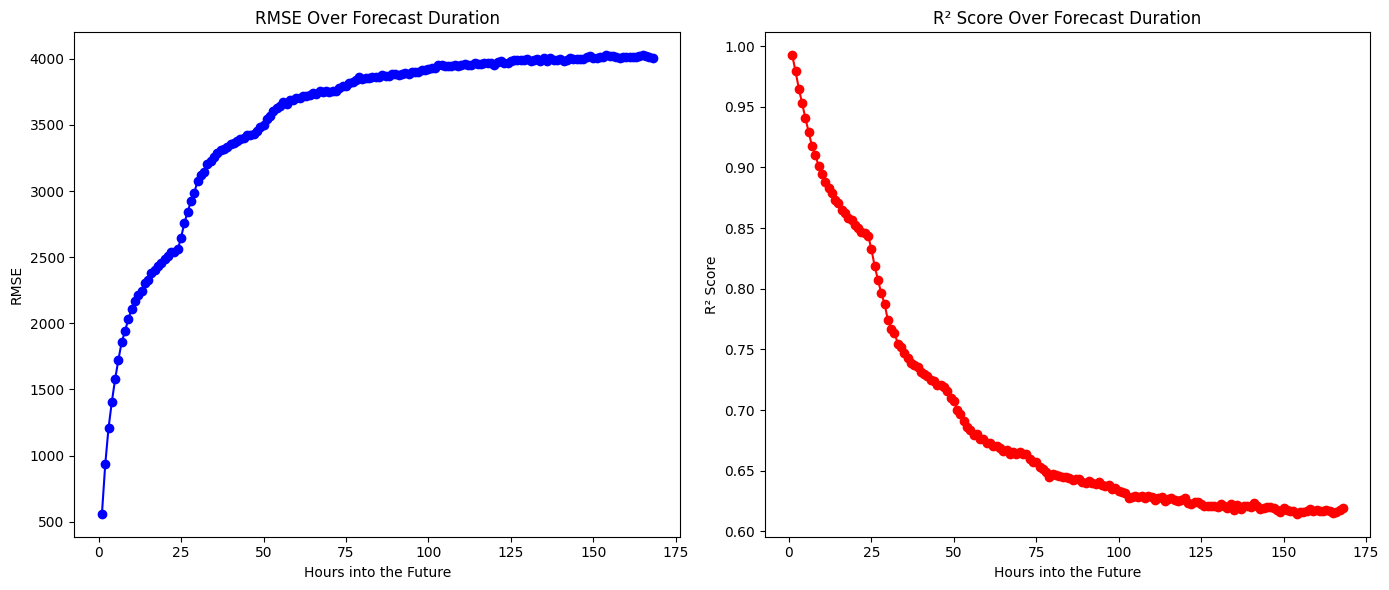

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate RMSE and R2 for each forecast hour
rmse_scores = [np.sqrt(mean_squared_error(y_test_rescaled[:, i], y_pred_rescaled[:, i])) for i in range(y_pred_rescaled.shape[1])]
r2_scores = [r2_score(y_test_rescaled[:, i], y_pred_rescaled[:, i]) for i in range(y_pred_rescaled.shape[1])]

# Plotting the results
hours = np.arange(1, y_pred_rescaled.shape[1] + 1)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(hours, rmse_scores, marker='o', linestyle='-', color='b')
plt.title('RMSE Over Forecast Duration')
plt.xlabel('Hours into the Future')
plt.ylabel('RMSE')

plt.subplot(1, 2, 2)
plt.plot(hours, r2_scores, marker='o', linestyle='-', color='r')
plt.title('R² Score Over Forecast Duration')
plt.xlabel('Hours into the Future')
plt.ylabel('R² Score')

plt.tight_layout()
plt.show()


# Model #4 - XGBoost with grid search using validation data


In [ ]:
# Normalize the feature(s)
scaler = MinMaxScaler()
pjme_data['scaled'] = scaler.fit_transform(pjme_data[['PJME_MW']].values)

In [ ]:
def create_features_targets(data, n_in, n_out):
    """
    data: input dataframe, expected a single column of data
    n_in: number of lag observations as input (X)
    n_out: number of outputs (y)
    """
    X, y = [], []
    for i in range(len(data) - n_in - n_out + 1):
        X.append(data[i:(i + n_in)].values)
        y.append(data[(i + n_in):(i + n_in + n_out)].values)
    return np.array(X), np.array(y)


In [ ]:
# Parameters
n_in = 24 * 14  # 14 days of data, assuming hourly steps
n_out = 24 * 7  # predicting the next 7 days

X, y = create_features_targets(pjme_data['scaled'], n_in, n_out)


In [ ]:
# Split the data into training, validation, and testing sets
split_train = int(0.7 * len(X))  # 70% for training
split_val = int(0.9 * len(X))    # 20% for validation, 10% for test

X_train, X_val, X_test = X[:split_train], X[split_train:split_val], X[split_val:]
y_train, y_val, y_test = y[:split_train], y[split_train:split_val], y[split_val:]

# Flatten the output arrays for training and validation
y_train_flat = y_train.reshape(y_train.shape[0], -1)
y_val_flat = y_val.reshape(y_val.shape[0], -1)
y_test_flat = y_test.reshape(y_test.shape[0], -1)


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the model
model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [50, 200],
    'max_depth': [3, 7]
}

# Setup the grid search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,  # Number of cross-validation folds (k-fold)
    scoring='neg_mean_squared_error',
    verbose=1
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train_flat, eval_set=[(X_val, y_val_flat)], early_stopping_rounds=10, verbose=True)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", np.sqrt(-grid_search.best_score_))

# Use the best estimator
best_model = grid_search.best_estimator_

# Predictions with the best model
y_pred = best_model.predict(X_test)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[0]	validation_0-rmse:0.11261
[1]	validation_0-rmse:0.09693
[2]	validation_0-rmse:0.08759
[3]	validation_0-rmse:0.08191
[4]	validation_0-rmse:0.07873
[5]	validation_0-rmse:0.07685
[6]	validation_0-rmse:0.07574
[7]	validation_0-rmse:0.07508
[8]	validation_0-rmse:0.07467
[9]	validation_0-rmse:0.07440
[10]	validation_0-rmse:0.07421
[11]	validation_0-rmse:0.07406
[12]	validation_0-rmse:0.07395
[13]	validation_0-rmse:0.07386
[14]	validation_0-rmse:0.07378
[15]	validation_0-rmse:0.07370
[16]	validation_0-rmse:0.07364
[17]	validation_0-rmse:0.07358
[18]	validation_0-rmse:0.07352
[19]	validation_0-rmse:0.07347
[20]	validation_0-rmse:0.07343
[21]	validation_0-rmse:0.07339
[22]	validation_0-rmse:0.07336
[23]	validation_0-rmse:0.07332
[24]	validation_0-rmse:0.07330
[25]	validation_0-rmse:0.07327
[26]	validation_0-rmse:0.07324
[27]	validation_0-rmse:0.07322
[28]	validation_0-rmse:0.07319
[29]	validation_0-rmse:0.07317
[30]	validation_0-rmse:0.07315
[31]	validation_0-rmse:0.07313
[32]	validation_0-

[0]	validation_0-rmse:0.11175
[1]	validation_0-rmse:0.09610
[2]	validation_0-rmse:0.08686
[3]	validation_0-rmse:0.08131
[4]	validation_0-rmse:0.07818
[5]	validation_0-rmse:0.07636
[6]	validation_0-rmse:0.07537
[7]	validation_0-rmse:0.07479
[8]	validation_0-rmse:0.07440
[9]	validation_0-rmse:0.07416
[10]	validation_0-rmse:0.07396
[11]	validation_0-rmse:0.07380
[12]	validation_0-rmse:0.07368
[13]	validation_0-rmse:0.07359
[14]	validation_0-rmse:0.07349
[15]	validation_0-rmse:0.07342
[16]	validation_0-rmse:0.07336
[17]	validation_0-rmse:0.07330
[18]	validation_0-rmse:0.07325
[19]	validation_0-rmse:0.07320
[20]	validation_0-rmse:0.07316
[21]	validation_0-rmse:0.07312
[22]	validation_0-rmse:0.07309
[23]	validation_0-rmse:0.07306
[24]	validation_0-rmse:0.07303
[25]	validation_0-rmse:0.07301
[26]	validation_0-rmse:0.07298
[27]	validation_0-rmse:0.07295
[28]	validation_0-rmse:0.07293
[29]	validation_0-rmse:0.07290
[30]	validation_0-rmse:0.07288
[31]	validation_0-rmse:0.07286
[32]	validation_0-

[0]	validation_0-rmse:0.11266
[1]	validation_0-rmse:0.09691
[2]	validation_0-rmse:0.08749
[3]	validation_0-rmse:0.08184
[4]	validation_0-rmse:0.07855
[5]	validation_0-rmse:0.07666
[6]	validation_0-rmse:0.07555
[7]	validation_0-rmse:0.07488
[8]	validation_0-rmse:0.07444
[9]	validation_0-rmse:0.07414
[10]	validation_0-rmse:0.07395
[11]	validation_0-rmse:0.07381
[12]	validation_0-rmse:0.07370
[13]	validation_0-rmse:0.07360
[14]	validation_0-rmse:0.07352
[15]	validation_0-rmse:0.07347
[16]	validation_0-rmse:0.07341
[17]	validation_0-rmse:0.07335
[18]	validation_0-rmse:0.07331
[19]	validation_0-rmse:0.07328
[20]	validation_0-rmse:0.07325
[21]	validation_0-rmse:0.07322
[22]	validation_0-rmse:0.07319
[23]	validation_0-rmse:0.07317
[24]	validation_0-rmse:0.07315
[25]	validation_0-rmse:0.07314
[26]	validation_0-rmse:0.07312
[27]	validation_0-rmse:0.07310
[28]	validation_0-rmse:0.07309
[29]	validation_0-rmse:0.07308
[30]	validation_0-rmse:0.07308
[31]	validation_0-rmse:0.07307
[32]	validation_0-

[0]	validation_0-rmse:0.11261
[1]	validation_0-rmse:0.09693
[2]	validation_0-rmse:0.08759
[3]	validation_0-rmse:0.08191
[4]	validation_0-rmse:0.07873
[5]	validation_0-rmse:0.07685
[6]	validation_0-rmse:0.07574
[7]	validation_0-rmse:0.07508
[8]	validation_0-rmse:0.07467
[9]	validation_0-rmse:0.07440
[10]	validation_0-rmse:0.07421
[11]	validation_0-rmse:0.07406
[12]	validation_0-rmse:0.07395
[13]	validation_0-rmse:0.07386
[14]	validation_0-rmse:0.07378
[15]	validation_0-rmse:0.07370
[16]	validation_0-rmse:0.07364
[17]	validation_0-rmse:0.07358
[18]	validation_0-rmse:0.07352
[19]	validation_0-rmse:0.07347
[20]	validation_0-rmse:0.07343
[21]	validation_0-rmse:0.07339
[22]	validation_0-rmse:0.07336
[23]	validation_0-rmse:0.07332
[24]	validation_0-rmse:0.07330
[25]	validation_0-rmse:0.07327
[26]	validation_0-rmse:0.07324
[27]	validation_0-rmse:0.07322
[28]	validation_0-rmse:0.07319
[29]	validation_0-rmse:0.07317
[30]	validation_0-rmse:0.07315
[31]	validation_0-rmse:0.07313
[32]	validation_0-

[0]	validation_0-rmse:0.11175
[1]	validation_0-rmse:0.09610
[2]	validation_0-rmse:0.08686
[3]	validation_0-rmse:0.08131
[4]	validation_0-rmse:0.07818
[5]	validation_0-rmse:0.07636
[6]	validation_0-rmse:0.07537
[7]	validation_0-rmse:0.07479
[8]	validation_0-rmse:0.07440
[9]	validation_0-rmse:0.07416
[10]	validation_0-rmse:0.07396
[11]	validation_0-rmse:0.07380
[12]	validation_0-rmse:0.07368
[13]	validation_0-rmse:0.07359
[14]	validation_0-rmse:0.07349
[15]	validation_0-rmse:0.07342
[16]	validation_0-rmse:0.07336
[17]	validation_0-rmse:0.07330
[18]	validation_0-rmse:0.07325
[19]	validation_0-rmse:0.07320
[20]	validation_0-rmse:0.07316
[21]	validation_0-rmse:0.07312
[22]	validation_0-rmse:0.07309
[23]	validation_0-rmse:0.07306
[24]	validation_0-rmse:0.07303
[25]	validation_0-rmse:0.07301
[26]	validation_0-rmse:0.07298
[27]	validation_0-rmse:0.07295
[28]	validation_0-rmse:0.07293
[29]	validation_0-rmse:0.07290
[30]	validation_0-rmse:0.07288
[31]	validation_0-rmse:0.07286
[32]	validation_0-

[0]	validation_0-rmse:0.11266
[1]	validation_0-rmse:0.09691
[2]	validation_0-rmse:0.08749
[3]	validation_0-rmse:0.08184
[4]	validation_0-rmse:0.07855
[5]	validation_0-rmse:0.07666
[6]	validation_0-rmse:0.07555
[7]	validation_0-rmse:0.07488
[8]	validation_0-rmse:0.07444
[9]	validation_0-rmse:0.07414
[10]	validation_0-rmse:0.07395
[11]	validation_0-rmse:0.07381
[12]	validation_0-rmse:0.07370
[13]	validation_0-rmse:0.07360
[14]	validation_0-rmse:0.07352
[15]	validation_0-rmse:0.07347
[16]	validation_0-rmse:0.07341
[17]	validation_0-rmse:0.07335
[18]	validation_0-rmse:0.07331
[19]	validation_0-rmse:0.07328
[20]	validation_0-rmse:0.07325
[21]	validation_0-rmse:0.07322
[22]	validation_0-rmse:0.07319
[23]	validation_0-rmse:0.07317
[24]	validation_0-rmse:0.07315
[25]	validation_0-rmse:0.07314
[26]	validation_0-rmse:0.07312
[27]	validation_0-rmse:0.07310
[28]	validation_0-rmse:0.07309
[29]	validation_0-rmse:0.07308
[30]	validation_0-rmse:0.07308
[31]	validation_0-rmse:0.07307
[32]	validation_0-

[0]	validation_0-rmse:0.11009
[1]	validation_0-rmse:0.09329
[2]	validation_0-rmse:0.08377
[3]	validation_0-rmse:0.07871
[4]	validation_0-rmse:0.07609
[5]	validation_0-rmse:0.07477
[6]	validation_0-rmse:0.07413
[7]	validation_0-rmse:0.07383
[8]	validation_0-rmse:0.07368
[9]	validation_0-rmse:0.07363
[10]	validation_0-rmse:0.07361
[11]	validation_0-rmse:0.07363
[12]	validation_0-rmse:0.07364
[13]	validation_0-rmse:0.07366
[14]	validation_0-rmse:0.07368
[15]	validation_0-rmse:0.07370
[16]	validation_0-rmse:0.07372
[17]	validation_0-rmse:0.07375
[18]	validation_0-rmse:0.07379
[19]	validation_0-rmse:0.07381


[0]	validation_0-rmse:0.10917
[1]	validation_0-rmse:0.09261
[2]	validation_0-rmse:0.08323
[3]	validation_0-rmse:0.07822
[4]	validation_0-rmse:0.07561
[5]	validation_0-rmse:0.07428
[6]	validation_0-rmse:0.07363
[7]	validation_0-rmse:0.07332
[8]	validation_0-rmse:0.07318
[9]	validation_0-rmse:0.07311
[10]	validation_0-rmse:0.07310
[11]	validation_0-rmse:0.07308
[12]	validation_0-rmse:0.07309
[13]	validation_0-rmse:0.07309
[14]	validation_0-rmse:0.07310
[15]	validation_0-rmse:0.07312
[16]	validation_0-rmse:0.07313
[17]	validation_0-rmse:0.07316
[18]	validation_0-rmse:0.07318
[19]	validation_0-rmse:0.07320
[20]	validation_0-rmse:0.07322
[21]	validation_0-rmse:0.07324


[0]	validation_0-rmse:0.10995
[1]	validation_0-rmse:0.09317
[2]	validation_0-rmse:0.08361
[3]	validation_0-rmse:0.07854
[4]	validation_0-rmse:0.07592
[5]	validation_0-rmse:0.07461
[6]	validation_0-rmse:0.07399
[7]	validation_0-rmse:0.07370
[8]	validation_0-rmse:0.07356
[9]	validation_0-rmse:0.07351
[10]	validation_0-rmse:0.07350
[11]	validation_0-rmse:0.07352
[12]	validation_0-rmse:0.07354
[13]	validation_0-rmse:0.07358
[14]	validation_0-rmse:0.07363
[15]	validation_0-rmse:0.07368
[16]	validation_0-rmse:0.07372
[17]	validation_0-rmse:0.07377
[18]	validation_0-rmse:0.07383
[19]	validation_0-rmse:0.07387


[0]	validation_0-rmse:0.11009
[1]	validation_0-rmse:0.09329
[2]	validation_0-rmse:0.08377
[3]	validation_0-rmse:0.07871
[4]	validation_0-rmse:0.07609
[5]	validation_0-rmse:0.07477
[6]	validation_0-rmse:0.07413
[7]	validation_0-rmse:0.07383
[8]	validation_0-rmse:0.07368
[9]	validation_0-rmse:0.07363
[10]	validation_0-rmse:0.07361
[11]	validation_0-rmse:0.07363
[12]	validation_0-rmse:0.07364
[13]	validation_0-rmse:0.07366
[14]	validation_0-rmse:0.07368
[15]	validation_0-rmse:0.07370
[16]	validation_0-rmse:0.07372
[17]	validation_0-rmse:0.07375
[18]	validation_0-rmse:0.07379
[19]	validation_0-rmse:0.07381
[20]	validation_0-rmse:0.07384


[0]	validation_0-rmse:0.10917
[1]	validation_0-rmse:0.09261
[2]	validation_0-rmse:0.08323
[3]	validation_0-rmse:0.07822
[4]	validation_0-rmse:0.07561
[5]	validation_0-rmse:0.07428
[6]	validation_0-rmse:0.07363
[7]	validation_0-rmse:0.07332
[8]	validation_0-rmse:0.07318
[9]	validation_0-rmse:0.07311
[10]	validation_0-rmse:0.07310
[11]	validation_0-rmse:0.07308
[12]	validation_0-rmse:0.07309
[13]	validation_0-rmse:0.07309
[14]	validation_0-rmse:0.07310
[15]	validation_0-rmse:0.07312
[16]	validation_0-rmse:0.07313
[17]	validation_0-rmse:0.07316
[18]	validation_0-rmse:0.07318
[19]	validation_0-rmse:0.07320
[20]	validation_0-rmse:0.07322


[0]	validation_0-rmse:0.10995
[1]	validation_0-rmse:0.09317
[2]	validation_0-rmse:0.08361
[3]	validation_0-rmse:0.07854
[4]	validation_0-rmse:0.07592
[5]	validation_0-rmse:0.07461
[6]	validation_0-rmse:0.07399
[7]	validation_0-rmse:0.07370
[8]	validation_0-rmse:0.07356
[9]	validation_0-rmse:0.07351
[10]	validation_0-rmse:0.07350
[11]	validation_0-rmse:0.07352
[12]	validation_0-rmse:0.07354
[13]	validation_0-rmse:0.07358
[14]	validation_0-rmse:0.07363
[15]	validation_0-rmse:0.07368
[16]	validation_0-rmse:0.07372
[17]	validation_0-rmse:0.07377
[18]	validation_0-rmse:0.07383
[19]	validation_0-rmse:0.07387


[0]	validation_0-rmse:0.11232
[1]	validation_0-rmse:0.09661
[2]	validation_0-rmse:0.08719
[3]	validation_0-rmse:0.08154
[4]	validation_0-rmse:0.07833
[5]	validation_0-rmse:0.07644
[6]	validation_0-rmse:0.07539
[7]	validation_0-rmse:0.07475
[8]	validation_0-rmse:0.07432
[9]	validation_0-rmse:0.07403
[10]	validation_0-rmse:0.07380
[11]	validation_0-rmse:0.07363
[12]	validation_0-rmse:0.07351
[13]	validation_0-rmse:0.07341
[14]	validation_0-rmse:0.07332
[15]	validation_0-rmse:0.07324
[16]	validation_0-rmse:0.07317
[17]	validation_0-rmse:0.07310
[18]	validation_0-rmse:0.07304
[19]	validation_0-rmse:0.07299
[20]	validation_0-rmse:0.07295
[21]	validation_0-rmse:0.07290
[22]	validation_0-rmse:0.07286
[23]	validation_0-rmse:0.07282
[24]	validation_0-rmse:0.07279
[25]	validation_0-rmse:0.07277
[26]	validation_0-rmse:0.07273
[27]	validation_0-rmse:0.07271
[28]	validation_0-rmse:0.07268
[29]	validation_0-rmse:0.07265
[30]	validation_0-rmse:0.07262
[31]	validation_0-rmse:0.07260
[32]	validation_0-

In [ ]:
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Rescale predictions back to the original scale
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_rescaled = scaler.inverse_transform(y_test_flat).flatten()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

# Output the performance metrics
print("RMSE on Test Data:", rmse)
print("R² Score on Test Data:", r2)


RMSE on Test Data: 3743.9848332845063
R² Score on Test Data: 0.6150528472592529


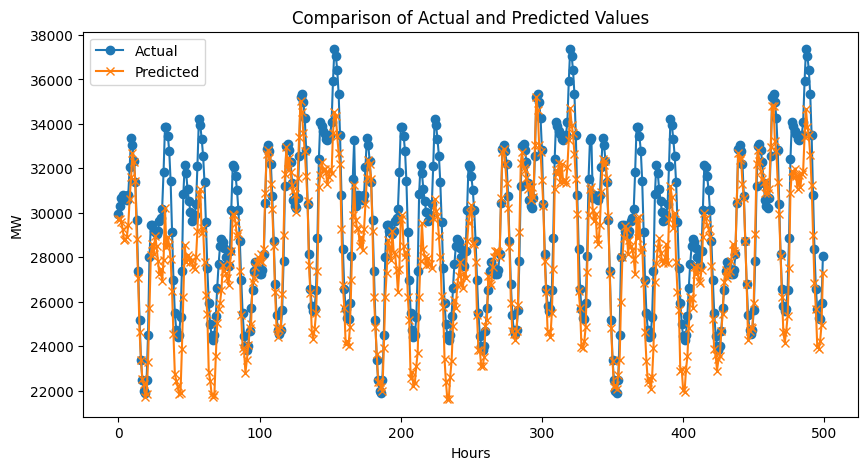

In [ ]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled[:500], label='Actual', marker='o')  # Plot the first week of actual data
plt.plot(y_pred_rescaled[:500], label='Predicted', marker='x')  # Plot the first week of predicted data
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Hours')
plt.ylabel('MW')
plt.legend()
plt.show()


In [ ]:
# Check current shapes
print("Shape of y_pred:", y_pred.shape)
print("Shape of y_test_flat:", y_test_flat.shape)

Shape of y_pred: (14489, 168)
Shape of y_test_flat: (14489, 168)


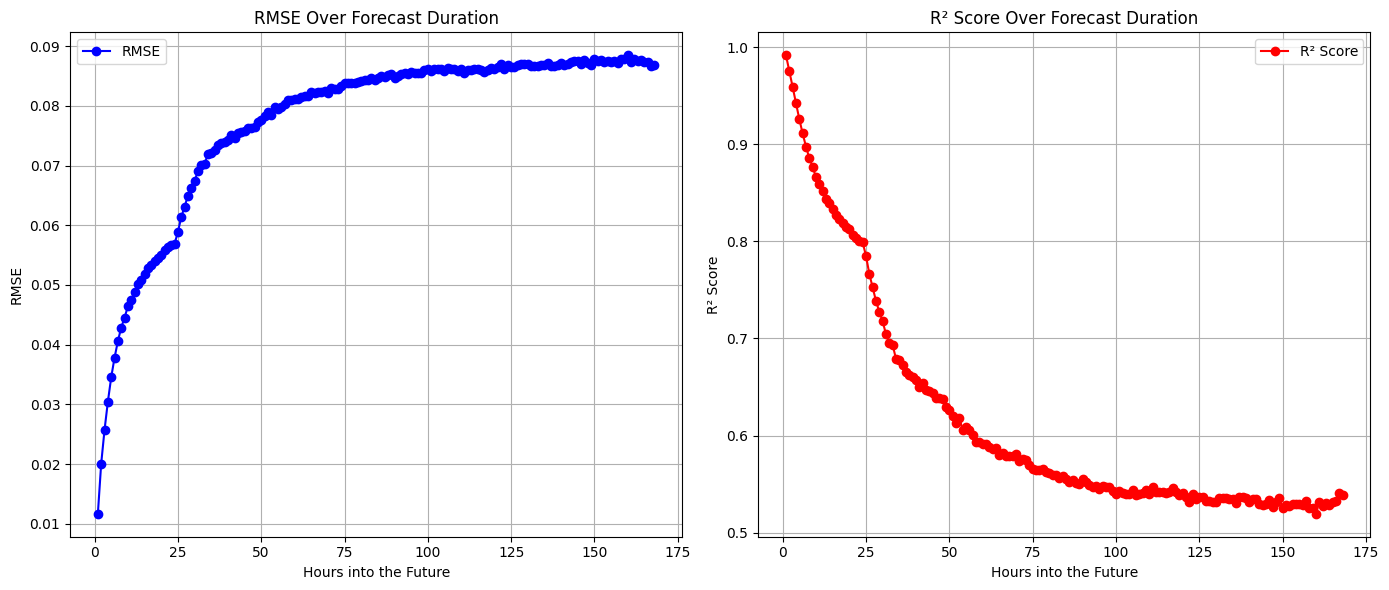

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Since y_pred and y_test_flat are already correctly shaped, proceed with calculations
rmse_scores = [np.sqrt(mean_squared_error(y_test_flat[:, i], y_pred[:, i])) for i in range(y_pred.shape[1])]
r2_scores = [r2_score(y_test_flat[:, i], y_pred[:, i]) for i in range(y_pred.shape[1])]

# Plotting the results
hours = np.arange(1, y_pred.shape[1] + 1)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(hours, rmse_scores, marker='o', linestyle='-', color='blue', label='RMSE')
plt.title('RMSE Over Forecast Duration')
plt.xlabel('Hours into the Future')
plt.ylabel('RMSE')
plt.grid(True)  # Adding grid for better readability
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hours, r2_scores, marker='o', linestyle='-', color='red', label='R² Score')
plt.title('R² Score Over Forecast Duration')
plt.xlabel('Hours into the Future')
plt.ylabel('R² Score')
plt.grid(True)  # Adding grid for better readability
plt.legend()

plt.tight_layout()
plt.show()
